# Multi-Agentic Recommendation System Pipeline
This notebook demonstrates a modular, multi-agentic pipeline for evaluating recommender systems with context engineering.

Each agent is responsible for a specific function, and context engineering is used to enhance the recommendation process.

In [1]:
# Go to root dir to load the code from `src` and dataset from the specific folder
import os
os.chdir("..")

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch

from scipy.sparse import lil_matrix

from prettytable import PrettyTable

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import Deduplicate, MinRating, MinItemsPerUser
from recpack.scenarios import WeakGeneralization, StrongGeneralization

from hyperopt import fmin, tpe, hp

# helpers & metrics
from src.helper_functions.data_formatting import *
from src.helper_functions.metrics_accuracy import *
from src.helper_functions.metrics_coverage import *
from src.helper_functions.metrics_exposure import *

# models
from src.recommenders.ease import myEASE
from src.recommenders.slim_bn import BNSLIM
from src.recommenders.fslr import FSLR
from src.recommenders.slim_bn_admm import BNSLIM_ADMM
from src.recommenders.mf_fair import FairMF
from src.recommenders.fda import FDA_bpr

import json
import re
import itertools
import time

# import pickle

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import logging

logging.basicConfig(filename="recsys.log", level=logging.WARN, format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger(__name__)

### Data loading

In [4]:
# load ratings.dat from ml-1m folder
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, usecols=[0,1,2,3], names=["User_id","Item_id","Rating","Timestamp"], engine="python")

# load movies.dat from ml-1m folder
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, usecols=[0,1,2], names=["Item_id", "Title", "Genre"], encoding="latin-1", engine="python")
movies["Genre"] = movies["Genre"].apply(lambda x: x.split("|"))
movies_items = movies
movies = movies.explode("Genre")

# load users.dat from ml-1m folder
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, usecols=[0,1], names=["User_id", "Gender"], encoding="latin-1", engine="python")

# replace "M" with 0 and "F" with 1 in the "Gender" column
users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})

# join ratings on users with User_id
ratings = pd.merge(ratings, users, on="User_id", how="left")
ratings['datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings = ratings.sort_values('datetime').reset_index(drop=True)

/var/folders/p_/s2y5jw396vjd9c8fql74n7600000gn/T/ipykernel_8945/2820513550.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})


### Data Preprocessing

#### Temporal Splitting

Split the dataset into train and test sets based on a timestamp for temporal evaluation.

* 50% oldest interactions for train (base set)
* 50% newest interactions for test

In [5]:
# Split ratings into train and test sets based on timestamp (temporal split)
# Example: Use the 80th percentile of timestamps as the split point
#split_point = ratings["Timestamp"].quantile(0.8)
split_point = ratings["Timestamp"].quantile(0.5) # 50% temporal split
train_ratings = ratings[ratings["Timestamp"] <= split_point]
test_ratings = ratings[ratings["Timestamp"] > split_point]

print(f"Train set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")
print(f"Split timestamp: {split_point}")
print(f"Split datetime: {pd.to_datetime(split_point, unit='s')}")


Train set size: 500105
Test set size: 500104
Split timestamp: 973018006.0
Split datetime: 2000-10-31 18:46:46


In [6]:
print("Train - Users: {} | Items: {} ".format(train_ratings.User_id.unique().shape[0],train_ratings.Item_id.unique().shape[0]))
print("Test - Users: {} | Items: {} ".format(test_ratings.User_id.unique().shape[0],test_ratings.Item_id.unique().shape[0]))

Train - Users: 3255 | Items: 3551 
Test - Users: 3415 | Items: 3643 


In [7]:
ratings_pp = DataFramePreprocessor("Item_id", "User_id","Timestamp")

# define filters
deduplicate = Deduplicate("Item_id", "User_id", "Timestamp")
min_rating_filter = MinRating(4, "Rating")
min_items_per_user_filter = MinItemsPerUser(10, "Item_id", "User_id") # Don't filter users with less than 10 interactions --- IGNORE ---

# add filters to pre-processor
ratings_pp.add_filter(deduplicate)
ratings_pp.add_filter(min_rating_filter)
ratings_pp.add_filter(min_items_per_user_filter)

# create interaction matrix object
# im = ratings_pp.process(ratings)
im_train = ratings_pp.process(train_ratings)
# im_test = ratings_pp.process(test_ratings)
#im, im_train, im_test = ratings_pp.process_many(ratings, train_ratings, test_ratings)

# apply filters to ratings frame directly
#ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(ratings)))
#train_ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(train_ratings)))
ratings = min_rating_filter.apply(deduplicate.apply(ratings))
train_ratings = min_rating_filter.apply(deduplicate.apply(train_ratings))

movies = movies[movies["Item_id"].isin(ratings["Item_id"].unique())] # only keep items that are in the filtered ratings
raw_genre_dict = dict(movies.groupby("Genre")["Item_id"].apply(lambda x: list(set(x))))

# genre - inner iids dictionary
inner_genre_dict = {
    genre: get_inner_item_ids(ratings_pp, raw_iids) for genre, raw_iids in raw_genre_dict.items()
}

  0%|          | 0/290311 [00:00<?, ?it/s]

  0%|          | 0/290311 [00:00<?, ?it/s]

In [8]:
#### UPDATE
# Remove year from movie titles for better readability
YEAR_MOVIE_TITLES_PATTERN = r'\s*\(\d{4}\)'
original_movie_titles = movies.Title.unique()

In [9]:
#### UPDATE
# Create a mapping from original titles to updated titles without year
original_to_updated_titles = {title : re.sub(YEAR_MOVIE_TITLES_PATTERN,'',title) for title in original_movie_titles}

In [10]:
#### UPDATE
# Fix titles that have ", The" or ", A" at the end
for title in original_to_updated_titles:
    if "," in original_to_updated_titles[title]:
        parts = original_to_updated_titles[title].split(",")
        if len(parts) == 2:
            if parts[1] == ' The':
                original_to_updated_titles[title] = 'The ' + parts[0]
            elif parts[1] == ' A':
                original_to_updated_titles[title] = 'A ' + parts[0]
        
updated_to_original_titles = {original_to_updated_titles[original_title] : original_title for original_title in original_to_updated_titles}

In [11]:
#### UPDATE
pd.DataFrame.sparse.from_spmatrix(im_train.binary_values).head()

,0,1,2,3,4,5,6,7,8,9,...,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
get_raw_user_ids(ratings_pp,[3]), get_inner_user_ids(ratings_pp,[6037])

(array([6037]), array([3]))

In [13]:
#print(f"Full data - U[{len(im.active_users)}] | I[{len(im.active_items)}]")
print(f"Base data - U[{len(im_train.active_users)}] | I[{len(im_train.active_items)}]")
#print(f"Test data - U[{len(im_test.active_users)}] | I[{len(im_test.active_items)}]")

Base data - U[3153] | I[3359]


## Data Statistics

### Full dataset

### Base dataset (50% oldest interactions)

In [14]:
# compute sparsity after filtering
sparsity = 1 - im_train.density

# calculate user interaction and item popularity ranges
user_interactions = im_train.binary_values.sum(axis=1)
item_popularities = im_train.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im_train.active_users)

# create uid - gender mapping df
gender_mapping_df = train_ratings[train_ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im_train.binary_values[inner_uids_f].sum(), im_train.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im_train.num_active_users), str(im_train.num_active_items), str(im_train.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 10 to 1063. Item popularity ranges from 1 to 1413.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 3153 | 3359 | 290311 |  97.26   |
+----------+------+------+--------+----------+
+----------+-----------+-----+--------+------+--------+
| data set | attribute | |F| | int(F) | |M|  | int(M) |
+----------+-----------+-----+--------+------+--------+
|   ML1M   |   gender  | 907 | 75923  | 2246 | 214388 |
+----------+-----------+-----+--------+------+--------+


In [15]:
inner_uids_m.shape[0], inner_uids_f.shape[0]

(2246, 907)

### Train and test backbones

In [16]:
SEED = 1994

In [17]:
class TrainedBackbones:
    
    def __init__(self,interaction_matrix):
        self.im = interaction_matrix
        
        # Create scenario for train and test the backbone        
        self.scenario = WeakGeneralization(validation=True, seed=SEED)
        self.scenario.split(self.im)

        # Load optimized parameters
        with open(f"ml-1m/{SEED}/opt_params.json", "r") as f: opt_params = json.load(f)
        # Initialize models
        self.models = self.initialize_models(opt_params)
        # Prepare to output
        self.predictions = dict()
        self.fit_time = dict()
        self.iters_num = dict()

        # Build the backbone models and generate the outputs
        self.train_test_models()
        
    def initialize_models(self,opt_params):
        return {
            "ease": myEASE(l2=opt_params["ease"]["l2"], method="user"),
        #   "bnslim": BNSLIM(knn=100, l1=opt_params["bnslim"]["l1"], l2=opt_params["bnslim"]["l2"], l3=opt_params["bnslim"]["l3"], maxIter=50, method="user", seed=SEED),
        #    "fslr": FSLR(l1=opt_params["fslr"]["l1"], l2=opt_params["fslr"]["l2"], method="user"),
        #    "bnslim_admm": BNSLIM_ADMM(l1=opt_params["bnslim_admm"]["l1"], l2=opt_params["bnslim_admm"]["l2"], l3=opt_params["bnslim_admm"]["l3"], method="user"),
        #    "fairmf": FairMF(batch_size=im.num_active_users, l2=opt_params["fairmf"]["l2"], learning_rate=opt_params["fairmf"]["learning_rate"], num_factors=opt_params["fairmf"]["num_factors"], seed=SEED),
        #    "fda": FDA_bpr(noise_ratio=opt_params["fda"]["noise_ratio"], num_ng=opt_params["fda"]["num_ng"],seed=SEED)
        }

    def train_test_models(self):

        #### PARAMETERS INIT
        # parameters for fairmf
        sst_field = torch.zeros((self.im.num_active_users, self.im.num_active_items), dtype=torch.bool)
        sst_field[inner_uids_f, :] = True
        # parameters for fda
        users_features = np.zeros(self.im.num_active_users); users_features[inner_uids_m] = 1

        for model_name, model in self.models.items():
            print(f"Training model {model_name}...")

            params = {}
            if model_name == "fslr":
                params = {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}
            elif model_name in ["bnslim", "bnslim_admm"]:
                params = {"inner_ids_npr": inner_uids_m}
            elif model_name == "fairmf":
                params = {"sst_field": sst_field}
            elif model_name == "fda":
                params = {"users_features": users_features}
            
            start_time = time.time()
            model.fit(self.scenario.full_training_data.binary_values, **params)
            self.fit_time[model_name] = time.time() - start_time
            print(f"Fit time: {self.fit_time}")

            if model_name == "fairmf":
                self.iters_num[model_name] = model.epochs
            else:
                self.iters_num[model_name] = model.iters

            # generate predictions and mask training interactions
            y_pred = None
            if model_name == "fda":
                y_pred = model.model_.predict()
            else:
                y_pred = model.predict(self.scenario.full_training_data.binary_values)
            self.predictions[model_name] = y_pred.toarray()
            # mask
            self.predictions[model_name][self.scenario.full_training_data.binary_values.nonzero()] = -np.inf

            for K in [10,20]:
                ndcg, std_ndcg = tndcg_at_n(self.predictions[model_name], self.scenario.test_data_out.binary_values, K)
                recall, std_recall = recall_at_n(self.predictions[model_name], self.scenario.test_data_out.binary_values, K)

                print(f"Model: {model_name} | NDCG@{K}: {ndcg:.4f} (±{std_ndcg:.4f}) | Recall@{K}: {recall:.4f} (±{std_recall:.4f})"  )


    def get_items_ranking(self, items_ids):
        raw_items_ids = get_raw_item_ids(ratings_pp,items_ids)      # RAW: from dataset
        #inner_items_ids = get_inner_item_ids(ratings_pp,items_ids) # INNER: used by recpack
        rec_items = []
        for i, item_id in enumerate(raw_items_ids):
            item_original_title = movies_items[movies_items.Item_id == item_id].Title.values[0]
            rec_item = {
                "item_id": int(item_id),
                "item_title": original_to_updated_titles[item_original_title],
                "position": i+1
            }
            rec_items.append(rec_item)

        return rec_items

    def get_candidate_items(self, user_id, model_name, top_k):
        user_top_items = get_topn_indices(self.predictions[model_name],top_k)[user_id]
        return self.get_items_ranking(user_top_items)

    def get_models_name(self):
        return self.models.keys()

    def get_raw_item_ids_from_titles_in_catalog(self, item_titles : list[str]):
        catalog = movies.drop_duplicates(subset=['Item_id','Title'])
        return catalog[catalog.Title.isin(item_titles)]['Item_id'].tolist()


#backbones = TrainedBackbones(im)
backbones = TrainedBackbones(im_train)

# define the models, list sizes, and metrics
#list_sizes = [10, 20, 50, 100]
list_sizes = [10,20]
metrics = ["recall",'recall_reranking',"ndcg", "ndcg_reranking", ## UPDATE
           "c-equity","c-equity_reranking", "u-parity","u-parity_reranking"] ## UPDATE

# initialize a dictionary to store results with mean and standard deviation
results = {
    "iters_num": {model: 0 for model in ["bnslim", "fslr", "bnslim_admm", "fairmf"]},
    "fit_time": {model: 0 for model in backbones.models.keys()},
    "reranking_sample_users": {model: 0 for model in backbones.models.keys()}, ## UPDATE
    **{metric: {model: {size: {"mean": 0, "std": 0} for size in list_sizes} for model in backbones.models.keys()} for metric in metrics},
}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Training model ease...
2025-12-17 23:09:10,542 - base - recpack - INFO - Fitting myEASE complete - Took 1.33s
Fit time: {'ease': 1.3444628715515137}
Model: ease | NDCG@10: 0.3066 (±0.2309) | Recall@10: 0.2915 (±0.2135)
Model: ease | NDCG@20: 0.3051 (±0.1935) | Recall@20: 0.3192 (±0.1952)


# Context Engineering Elements Recommender System
Define modular functions/classes for each context element.

|Modelo| ($) input | ($) Cached input | ($) Output | Ref.
|---|---|---|---|---|
| gpt-4.1-nano | 0.10 | 0.025 | 0.40 | https://platform.openai.com/docs/models/gpt-4.1-nano
| gpt-5-nano | 0.05 | 0.005 | 0.40 | https://platform.openai.com/docs/models/gpt-5-nano

In [18]:
MODEL_NAME = "gpt-4.1-nano"
#MODEL_NAME = "gpt-5-nano"

In [19]:
os.environ['LANGSMITH_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGSMITH_PROJECT'] = "ml-agentic-recommender"

In [20]:
base_im = im_train # The interaction matrix to use in tools

## CMem - Memory Structure

> Memory ID: An experiment number (experiment_id). Can be a fixed value. Same value for user and system space.

### User space (namespace for memory)
* Level 1: user_id
* Level 2: the "memories" (e.g. user preferences, recommended items, ...)

**User's memories:**
* "preferences": avoid request preferences multiple times for the same user.
* "recommendations": avoid repeat some already recommended item for the user.


### System space (global state):
* Level 1: "system"
* Level 2: "counter" # Count how many request are done in the system

### System space -- Metrics
* Level 1: "metrics"
* Leve 2: 
    * "c-equity": exposure metric for C-fairness
    * "u-parity": coverage metric for C-fairness

In [21]:
experiment_id = 1

## CTools

### Get User History

In [22]:
from langchain.tools import tool, ToolRuntime

@tool("GetUserHistory",description="Get the history of items of the user from the oldest to newest watched movie.")
def get_user_history(user_id:int) -> str:
        
    print(f"[GetUserHistory] user_id: {user_id}")
    logger.info(f"[GetUserHistory] user_id: {user_id}")
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    
    raw_user_id = get_raw_user_ids(ratings_pp,[inner_user_id])[0]
    raw_item_ids = get_raw_item_ids(ratings_pp,inner_item_ids)

    movies_id_title = movies.loc[movies.Item_id.isin(raw_item_ids),['Item_id','Title']].drop_duplicates()
    movies_id_title.Title = movies_id_title.Title.apply(lambda x : original_to_updated_titles[x])
    movies_id_title['User_id'] = raw_user_id

    return ', '.join(pd.merge(movies_id_title,ratings,on=['User_id','Item_id']).sort_values('Timestamp').reset_index(drop=True)[['Title']].values.reshape(-1))

#get_user_history({"user_id":0})


In [23]:
@tool("GetNotInteractedItemsByTheUser",description="Get all items from the catalog which the user has not interacted with.")
def get_non_interacted_items(user_id:int) -> list[int]:
    
    logger.info(f"[GetNotInteractedItemsByTheUser] user_id: {user_id}")
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    all_inner_item_ids = set(base_im.active_items)
    non_interacted_inner_item_ids = list(all_inner_item_ids - set(inner_item_ids))
    raw_not_interacted_item_ids = get_raw_item_ids(ratings_pp,non_interacted_inner_item_ids)

    return '; '.join(movies_items.loc[movies_items.Item_id.isin(raw_not_interacted_item_ids),'Title'].apply(lambda x : original_to_updated_titles[x]).values)

#get_non_interacted_items(0)

### Filter candidate set

In [24]:
@tool("FilterCandidateSet",description="Get the filtered items from the backbone recommender model to compose the candidate set for recommendation.")
def get_user_candidate_set(user_id : int, top_k : int = 20, backbone_model_name : str ="ease") -> str:
    
    print(f"[FilterCandidateSet] User[{user_id}], Model: {backbone_model_name}, Top K: {top_k}")
    logger.info(f"[FilterCandidateSet] User[{user_id}] - Model: {backbone_model_name}, Top K: {top_k}")

    return ', '.join([ item['item_title'] for item in backbones.get_candidate_items(user_id, backbone_model_name,top_k) ])

#get_user_candidate_set({"user_id":0})

In [25]:
def collaborative_filtering(im,user_id,num_sim_users, num_items):
    # TODO: Fazer filtragem colaborativa comum
    similarity_matrix = im.binary_values @ im.binary_values.T
    sim_mat = similarity_matrix.toarray()
    pass

### Generate User Preferences

In [26]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.types import Command
from langchain.agents import AgentState
from pydantic import BaseModel

from typing import List

class UserContext(BaseModel):
    user_id: int
    session_id : int

class RecommenderAgentState(AgentState):  
    preferences: str
    recommended_items: List[str]

@tool("GetUserPreferences",description="Infer the user preferences based on the user history of watched movies.")
def get_user_preferences(user_history:str, runtime:ToolRuntime[UserContext,RecommenderAgentState]) -> str:

    # # Context
    # if runtime.context:
    #     print(f"[GetUserPreferences - context] Context: {runtime.context}")

    print(f"[GetUserPreferences] User[{runtime.context.user_id}] history length: {len(user_history)}")
    logger.info(f"[GetUserPreferences] User[{runtime.context.user_id}] history length: {len(user_history)}")
    if(len(user_history.strip())==0):
        logger.warning(f"[GetUserPreferences] No User[{runtime.context.user_id}] history available.")
        return "No user history available. Preferences cannot be inferred."
    
    # Memory
    namespace_for_memory = (str(runtime.context.user_id),"preferences")
    if runtime.store:
        user_memory = runtime.store.get(namespace_for_memory,experiment_id)
        if user_memory is not None:
            user_prefs = user_memory.value['infered_preferences'] or None
            if user_prefs is not None: # Using already generated preferences
                logger.info(f"[GetUserPreferences - Memory] User[{runtime.context.user_id}] Using existent preferences found in memory.")
                return Command(update={
                    "preferences": user_prefs,
                    "messages":[
                        ToolMessage(
                            user_prefs,
                            tool_call_id=runtime.tool_call_id
                        )
                    ]
                })

    # New inference of preferences
    system_msg = SystemMessage("You are a movie recommender specialist, tell me what are my preferences and explain them.")
    preferences_msg = HumanMessage(f"The movies I have watched (watched movies): {user_history}.\n\nWhat features are most important to me when selecting movies (Summarize my preferences briefly)?")

    messages = [
        system_msg,preferences_msg
    ]

    model = init_chat_model(MODEL_NAME)

    response = model.invoke(messages)  # Returns AIMessage
    
    # Storing inferred preferences in the Memory
    preference_memory = {"infered_preferences":response.content}
    runtime.store.put(namespace_for_memory, experiment_id, preference_memory,index=False)
    logger.info(f"[GetUserPreferences - Memory] User[{runtime.context.user_id}] inferred preferences stored in memory.")
    # Tool response
    return Command(update={
        "preferences": response.content,
        "messages":[
            ToolMessage(
                response.content,
                tool_call_id=runtime.tool_call_id
            )
        ]
    })

#get_user_preferences("Moral Kombat, Fast and Furios")
# model = init_chat_model(MODEL_NAME)
# model_with_tools = model.bind_tools([get_user_preferences])
# response = model_with_tools.invoke("My watch history is Moral Kombat and Fast Furios. What are my preferences ")
# print(response)

### Check Recommendations

In [27]:
def get_user_group(user_id):
    if user_id in inner_uids_m:
        return "non-protected"
    elif user_id in inner_uids_f:
        return "protected"
    else:
        return "undefined"

get_user_group(3)

'protected'

In [ ]:
from pydantic import BaseModel, Field
from typing import List

# Expected output format
class RecommendationResponse(BaseModel):
    """A list of recommended movies for the user."""
    user_id : int = Field(description="The user id of the generated recommendation list.")
    recommendations: List[str] = Field(description="A list of recommended movie titles")

def get_final_recommendation_list(recommended_titles : List[str]) -> List[str]:
    # Normalization of titles
    recommended_titles = [title.strip() for title in recommended_titles] # Response normalization
    available_in_original_title_lower = [title.lower() for title in original_to_updated_titles] # Normalize titles from the original catalog
    available_in_updated_title_lower = [title.lower() for title in updated_to_original_titles] # Normalize titles from the updated catalog (cleaned titles)

    final_recommendations = []

    # Check if recommended titles are in the catalog
    for title in recommended_titles:
        lower_generated_title = title.lower()
        if lower_generated_title in available_in_original_title_lower:
            final_recommendations.append( original_to_updated_titles[[t for t in original_to_updated_titles if t.lower() == lower_generated_title][0]] )
            continue
        elif lower_generated_title in available_in_updated_title_lower:
            final_recommendations.append( [t for t in updated_to_original_titles if t.lower() == lower_generated_title][0] )
            continue
        else:
            # If the title is not found in either catalog, stop and ask for new recommendations
            raise ValueError(f"The recommended movie `{title}` are not available in the catalog.")
    
    return final_recommendations

@tool("CheckRecommendations",description="Get a list of recommended movies and check if they are available in the catalog.")
def check_recommendations(result:RecommendationResponse, runtime: ToolRuntime[UserContext,RecommenderAgentState]) -> str:
    
    print(f"[CheckRecommendations] User[{runtime.context.user_id}] - Recommendations length: {len(result.recommendations)}")
    
    final_recommendations = []
    try:
        final_recommendations = get_final_recommendation_list(result.recommendations)
    except ValueError as ve:
        logger.warning(f"[CheckRecommendations] {ve} for the user[{runtime.context.user_id}].")
        return f"{ve}. Please recommend another movie."

    
    # Update memory with new recommended items
    namespace_for_memory = (str(runtime.context.user_id),"recommendations")
    if runtime.store:
        user_memory = runtime.store.get(namespace_for_memory,experiment_id)
        if user_memory is not None:
            user_previous_recs = user_memory.value.get('recommended_items',[])
            logger.info(f"[CheckRecommendations] User[{runtime.context.user_id}] already has recommendations: {user_previous_recs}")
            
            for title in final_recommendations:
                if title not in user_previous_recs:
                    user_previous_recs.append(title)
                else:
                    logger.warning(f"[CheckRecommendations] Title {title} already in recommended_items for user[{runtime.context.user_id}].")
            
            runtime.store.put(namespace_for_memory, experiment_id, {"recommended_items": user_previous_recs, "user_group": get_user_group(runtime.context.user_id)}, index=False)
        else:
            # First time recommendations for the user, storing them in the memory
            logger.info(f"[CheckRecommendations] Storing first recommendations for User[{runtime.context.user_id}]: {final_recommendations}")
            runtime.store.put(namespace_for_memory, experiment_id, {"recommended_items": final_recommendations, "user_group": get_user_group(runtime.context.user_id)}, index=False)
    else:
        logger.warning(f"[CheckRecommendations] There is no memory in the recommendation for the user[{runtime.context.user_id}]")
     

    # Return the final recommendations
    return Command(update={
        "recommended_items": final_recommendations,
        "messages":[
            ToolMessage(
                f"All recommended movies are available in the catalog. They are added to the memory.",
                tool_call_id=runtime.tool_call_id
            )
        ]
    })


## CState

#### Original metrics calculation (from Fair Neighborhood backbone models)

In [99]:
available_in_updated_title_lower = [title.lower() for title in updated_to_original_titles] # Normalize titles from the updated catalog (cleaned titles)


In [100]:
def get_metrics(user_id,recommendation_list, K, model_name="ease"):
    
    final_recommendations = []
    try:
        final_recommendations = get_final_recommendation_list(recommendation_list)
    except ValueError as ve:
        logger.warning(f"[GetMetrics] {ve} for the user[{user_id}].")
        return {}

    # map recommended titles back to original titles in the dataset and get their inner ids in the backbone matrix
    original_recommended_titles = [ updated_to_original_titles[recommended_movie] for recommended_movie in final_recommendations]
    recommended_raw_item_ids = backbones.get_raw_item_ids_from_titles_in_catalog(original_recommended_titles)
    recommended_inner_item_ids = get_inner_item_ids(ratings_pp,recommended_raw_item_ids)


    # generated_predictions = backbones.predictions[model_name].copy() # With copy, does not change the original matrix
    generated_predictions = backbones.predictions[model_name]
    max_val = generated_predictions[user_id].max() # Get the greatest relevance score generated by the backbone for the user
    # generated_predictions[resp.user_id,:] = -np.inf # Mask all items (need to check) 
    generated_predictions[user_id,recommended_inner_item_ids] = max_val + 0.5 # Force the reranked recommendations to have a greater score than backbone predictions

    cequity_mean, cequity_std, _ = c_equity_at_n(generated_predictions[inner_uids_f, :], generated_predictions[inner_uids_m, :], inner_genre_dict, K)
    #print(f"Reranking With: {model_name} | C-Equity@{K}: {cequity_mean:.4f} (±{cequity_std:.4f})" )

    # Coverage
    females = np.ones(base_im.num_active_users); females[inner_uids_m] = 0
    # Reranked
    uparity_mean, uparity_std = u_parity_at_n(generated_predictions,females, inner_genre_dict, K)
    #print(f"Reranking With: {model_name} | U-Parity@{K}: {uparity_mean:.4f} (±{uparity_std:.4f})" )
    return {
        "c-equity-mean": cequity_mean,
        "c-equity-std": cequity_std,
        "u-parity-mean": uparity_mean,
        "u-parity-std": uparity_std
    }

#get_metrics(resp.user_id,resp.recommendations,10,"ease") # `resp` is generated after agent invoke

### Reranking Metrics (fairness metrics)

In [101]:
from langchain.agents.middleware import after_agent
from langgraph.runtime import Runtime
from typing import Any

# Runs after the agent completes its execution (a reranking/recommendation is made)
@after_agent(state_schema=RecommenderAgentState)
def calculate_metrics(state: RecommenderAgentState, runtime: Runtime) -> dict[str, Any] | None:
    result : RecommendationResponse = state['structured_response']

    # c-fairness == consumer fairness (c-equity and u-parity)
    c_fairness_metrics = get_metrics(result.user_id,result.recommendations,10,"ease")

    recommender_counter = 1 # If memory fails, always overwrite with the last values at counter `1`
    # Get/Update System "STATE"/MEMORY (metrics calculation)
    if runtime.store:
        ## Get/Update recommender counter
        system_namespace = ("system","counter")
        system_memory = runtime.store.get(system_namespace,experiment_id)
        if system_memory is not None:
            recommender_counter = system_memory.value.get('recommender_counter',0)
            recommender_counter += 1
            
        runtime.store.put(system_namespace, experiment_id, {"recommender_counter": recommender_counter}, index=False)
        logger.info(f"Generated Recommendation: {recommender_counter}")
    
    ## Store the metric @ this point (recommender counter)
    namespace_for_cequity = ("metrics","c-equity")
    namespace_for_uparity = ("metrics","u-parity")

    #if recommender_counter % 5 == 0: # Calculate every 5 recommendations
    print(f"Metrics@{recommender_counter}: C-Equity: {c_fairness_metrics['c-equity-mean']:.4f} (±{c_fairness_metrics['c-equity-std']:.4f}), U-Parity: {c_fairness_metrics['u-parity-mean']:.4f} (±{c_fairness_metrics['u-parity-std']:.4f})")
    
    runtime.store.put(namespace_for_cequity,recommender_counter,{
                                                                 "user_id": result.user_id,
                                                                 "mean": c_fairness_metrics['c-equity-mean'], 
                                                                 "std": c_fairness_metrics['c-equity-std']
                                                                }, index=False)
    runtime.store.put(namespace_for_uparity,recommender_counter,{
                                                                 "user_id": result.user_id,
                                                                 "mean": c_fairness_metrics['u-parity-mean'],
                                                                 "std": c_fairness_metrics['u-parity-std']
                                                                }, index=False)
        
    return {"messages": "Recommender state updated.", "jump_to": "end"}
    

In [102]:
def get_movie_genres(movie_title):
    original_title = updated_to_original_titles[movie_title]
    return movies_items[movies_items.Title == original_title]['Genre'].values[0]

get_movie_genres("Seven Samurai (The Magnificent Seven) (Shichinin no samurai)")

['Action', 'Drama']

In [103]:
from langgraph.store.memory import InMemoryStore,BaseStore

def format_item_distribution(items_distribution:dict) -> str:
    non_protected_dist = "## Non-protected group items distribution:\n"
    if 'non-protected' in items_distribution:
        non_protected_dist += "\n".join( [ f"* {category}: {items_distribution['non-protected'][category]}" for category in items_distribution['non-protected']] )
    else:
        non_protected_dist += "There is no distribution for non-protected users group. No one user from this group get recommendation."

    protected_dist = "## Protected group items distribution:\n"
    if 'protected' in items_distribution:
        protected_dist += "\n".join( [ f"* {category}: {items_distribution['protected'][category]}" for category in items_distribution['protected']] )
    else:
        protected_dist += "There is no distribution for protected users group. No one user from this group get recommendation."
    
    return protected_dist + "\n\n" + non_protected_dist

def get_item_distribution(store:BaseStore):
    # Get all users with recommendation
    namespace_for_uparity = ("metrics","u-parity")
    u_parity_items = store.search(namespace_for_uparity)
    users = set([item.value.get('user_id') for item in u_parity_items])
    # For each user with recommendation, get the recommended items and the user group
    categories_distribution = dict()
    for user in users:
        # User Group
        user_group = get_user_group(user)
        if user_group not in categories_distribution:
            categories_distribution[user_group] = dict()

        # Recommended items
        namespace_for_user = (str(user),"recommendations")
        user_item = store.get(namespace_for_user,experiment_id)
        if user_item is None:
            logger.warning(f"[get_item_distribution] No recommendations found for user[{user}].")
            print("Sem recomendações para o usuário:", user)
            continue

        user_recommended_items = user_item.value.get("recommended_items")
        
        # Categories of recommended items
        for movie in user_recommended_items:
            movie_categories = get_movie_genres(movie)
            for category in movie_categories:
                if category not in categories_distribution[user_group]:
                    categories_distribution[user_group][category] = 0
                categories_distribution[user_group][category] = categories_distribution[user_group][category] + 1
        
    return categories_distribution
  

In [104]:
@tool("GetCurrentState",description="Get the current state of the recommender based on the target metric.")
def get_current_state(runtime: ToolRuntime):
    print("[GetCurrentState] --->>>")
    logger.info(f"Getting system state for the user {runtime.context.user_id}")
    if runtime.store:
        # System
        system_namespace = ("system","counter")
        system_memory = runtime.store.get(system_namespace,experiment_id)
        recommender_counter = 0
        if system_memory is None:
            print("[1] Primeira recomendação sem system memory")
            return "It is the first recommendation."
        else:
            recommender_counter = system_memory.value.get('recommender_counter',0)
            if recommender_counter == 0:
                print("[2] Primeira recomendação com system memory")
                return "It is the first recommendation."
        
        # u-parity
        namespace_for_uparity = ("metrics","u-parity")
        u_parity_item = runtime.store.get(namespace_for_uparity,recommender_counter)
        u_parity = u_parity_item.value.get("mean")
        print(f"[State] Com u-parity: {u_parity}")
        categories_distribution = get_item_distribution(runtime.store)
        formated_categories_distribution = format_item_distribution(categories_distribution)
        return f"Current u-parity: {u_parity}.\n\n# Categories distribution\n{formated_categories_distribution}"
    else:
        print("\t Sem memória")
        return "It is the first recommendation."


## CInst (System Instruction) - Agent Orchestration

**WITHOUT FAIRNESS**
You are a movie recommender specialist.

To recommend movies, you follow the steps:
1. Get the user history of watched movies.
2. Filter a candidate set of movies for the user.
3. Based on the user history, always get the user preferences.
4. Recommend 10 movies from the candidate set based on the users' preferences. The output should be a list of 10 movie titles only, without any additional text.
5. Check if the recommended movies are available in the catalog. If any movie is not available, recommend another movie from the candidate set and replace the wrong one.
6. If all recommended movies are available, output only the list of 10 movie titles and stop.

# You are a fair movie recommender specialist.

To recommend movies, you follow the steps:
1. Get the user history of watched movies.
2. Filter a candidate set of movies for the user.
3. Based on the user history, always get the user preferences.
4. Recommend 10 movies from the candidate set based on the users' preferences. The output should be a list of 10 movie titles only, without any additional text.
   * Check the system state to be fair based on the target metric. Use the tool `GetRecommendedItemDistribution`.
5. Check if the recommended movies are available in the catalog. If any movie is not available, recommend another movie from the candidate set and replace the wrong one.
6. If all recommended movies are available, output only the list of 10 movie titles and stop.


## Target Metric
You must use the u-parity metric to be fair.
The User-coverage Parity metric (u-parity) measures the disparity between the proportions of users from protected (Gp) and non-protected (Gnp) receiving recommendations from an item category, averaged across all categories. Scores range from 0 to 1, with 0 indicating that equal percentages of users (from both groups) receive recommendations from each item category and 1 indicating a rare scenario where each item category covers users from only one group.
u-parity helps identify if there is an imbalance in how different user groups are covered by recommendations across categories.

The protected group (Gp) is composed of women, and the unprotected group (Gnp) is composed of men.

In [105]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore 
from langchain.agents.middleware import ToolRetryMiddleware

model = ChatOpenAI(model=MODEL_NAME)

system_prompt = """
# You are a fair movie recommender specialist.

# Instructions
To recommend movies, you follow the steps:
1. Get the user history of watched movies.
2. Filter a candidate set of movies for the user.
3. Based on the user history, get the user preferences.
4. Recommend 10 movies from the candidate set based on the users' preferences. Check the current system state to be fair based on the target metric. Use the tool `GetCurrentState` to get the state.
5. Check if the recommended movies are available in the catalog. If any movie is not available, recommend another movie from the candidate set and replace the wrong one.
6. If all recommended movies are available, output only the list of 10 movie titles and stop.

Run each step one time, except if you need recommend another movie to replace a wrong one.

## Target Metric
You must use the u-parity metric to be fair.
The User-coverage Parity metric (u-parity) measures the disparity between the proportions of users from protected (Gp) and non-protected (Gnp) receiving recommendations from an item category, averaged across all categories. Scores range from 0 to 1, with 0 indicating that equal percentages of users (from both groups) receive recommendations from each item category and 1 indicating a rare scenario where each item category covers users from only one group.
u-parity helps identify if there is an imbalance in how different user groups are covered by recommendations across categories.

The protected group (Gp) is composed of women, and the unprotected group (Gnp) is composed of men.

The target u-parity is: 0.05.

# Output Format
The output should be a list of 10 movie titles only, without any additional text.
"""

tools = [get_user_history,get_user_candidate_set,get_user_preferences,get_current_state,check_recommendations]

checkpointer = InMemorySaver() # Unused
store = InMemoryStore() # In-memory store for context and state / memory - Instantiate once per experiment

# Agent with all components of the recommender system in Context Engineering paradigm
agent = create_agent(
    model,
    middleware=[calculate_metrics, ToolRetryMiddleware(
            max_retries=3,
            backoff_factor=2.0,
            initial_delay=1.0,
        )], # Cstate / Metrics
    tools=tools, # Ctools
    context_schema=UserContext, # Context control by user ID
    system_prompt=system_prompt, # Cinst
    response_format=ToolStrategy(RecommendationResponse), # Response format
    state_schema=RecommenderAgentState, # Last Recommendation
    checkpointer=checkpointer, # Unused
    store=store # Cmem / Cstate
)

## CQuery

## SEM FAIRNESS

f"Recommend movies for the user {user_id}"}


## COM FAIRNESS

f"Recommend movies for the user {user_id}. The user is in {group}."}

### Experiment setup (users to test)

In [106]:
users_to_test = backbones.im.num_active_users
users_to_test

3153

In [107]:
RETRY_ALLOWED = 3

users_with_recommendations = []

for user_id in range(0,3):
    n_try = 1
    while n_try < RETRY_ALLOWED:
        try:
            config = {"configurable":{"thread_id": f"experiment_{experiment_id}","user_id": user_id}}

            print(f"\n# Prompt[{user_id}]: Recommend movies for the user {user_id}. The user is in {get_user_group(user_id)} group.")
            result = agent.invoke(
                {
                    "messages": [{"role": "user", "content": f"Recommend movies for the user {user_id}. The user is in {get_user_group(user_id)} group."}],
                },
                config=config,
                context=UserContext(user_id=user_id,session_id=experiment_id)
            )
            users_with_recommendations.append(user_id)
            break # If successfull, continue to the next user.
            #print(result['messages'][-1].pretty_print())
        except Exception as e:
            logger.warning(f"[Users loop] - Problem generating recommendation for the User[{user_id}]: {e}")
            n_try += 1
            if n_try >= RETRY_ALLOWED:
                logger.error(f"[Users loop] - Error: it was not possible generate recommendation for the user[{user_id}]: {e}")
        


# Prompt[0]: Recommend movies for the user 0. The user is in non-protected group.
[GetUserHistory] user_id: 0
[FilterCandidateSet] User[0], Model: ease, Top K: 20
[GetUserPreferences] User[0] history length: 4033
[GetCurrentState] --->>>
[1] Primeira recomendação sem system memory
[CheckRecommendations] User[0] - Recommendations length: 10
Recomendações OK
Metrics@1: C-Equity: 0.0411 (±0.0426), U-Parity: 0.0735 (±0.0542)

# Prompt[1]: Recommend movies for the user 1. The user is in protected group.
[GetUserHistory] user_id: 1
[FilterCandidateSet] User[1], Model: ease, Top K: 20
[GetUserPreferences] User[1] history length: 1650
[GetCurrentState] --->>>
[State] Com u-parity: 0.07350999760119094
[CheckRecommendations] User[1] - Recommendations length: 10
Recomendações OK
Metrics@2: C-Equity: 0.0409 (±0.0425), U-Parity: 0.0731 (±0.0542)

# Prompt[2]: Recommend movies for the user 2. The user is in protected group.
[GetUserHistory] user_id: 2
[FilterCandidateSet] User[2], Model: ease, Top 

In [70]:
users_with_recommendations

[0, 1, 2]

# Calculate final result

In [130]:
# u-parity
namespace_for_uparity = ("metrics","u-parity")
metric_items = store.search(namespace_for_uparity)
uparity_list = []
for metric in metric_items:
    print(f"u-parity@{metric.key}" , metric.value['mean'])
    uparity_list.append(metric.value)

# c-equity
namespace_for_cequity = ("metrics","c-equity")
metric_items = store.search(namespace_for_cequity)
cequity_list = []
for metric in metric_items:
    print(f"c-equity@{metric.key}" , metric.value['mean'])
    cequity_list.append(metric.value)

u-parity@1 0.0731907836425877
u-parity@2 0.0731907836425877
c-equity@1 0.04092017234772063
c-equity@2 0.04092017234772063


In [51]:
store.search(("system",))

[Item(namespace=['system', 'counter'], key='1', value={'recommender_counter': 3}, created_at='2025-12-18T02:19:50.107125+00:00', updated_at='2025-12-18T02:19:50.107129+00:00', score=None)]

In [71]:
store.search(("2",))

[Item(namespace=['2', 'preferences'], key='1', value={'infered_preferences': "Based on your movie list, your preferences indicate a diverse but somewhat distinctive set of traits:\n\n1. **Classic and Cult Films:** You enjoy iconic classics and cult favorites like *Star Wars: Episode VI - Return of the Jedi*, *A Fish Called Wanda*, *Monty Python and the Holy Grail*, and *The Wrong Trousers*, suggesting an appreciation for humor, satire, and films with memorable cultural impact.\n\n2. **Humor and Whimsy:** Several comedies and lighthearted films such as *St. Elmo's Fire*, *A Fish Called Wanda*, *Harvey*, and animated comedies like *A Grand Day Out* point to a love of humor—ranging from witty and satirical to absurd and slapstick.\n\n3. **Dramas and Emotional Depth:** Movies like *Forrest Gump*, *Auntie Mame*, *Eat Drink Man Woman*, and *The English Patient* reflect an interest in emotionally resonant stories, character-driven narratives, and films that explore human relationships and per

In [131]:
df_result = pd.DataFrame(uparity_list,columns=['mean','std']).rename(columns={"mean":"u-parity", "std":'u-parity_std'}).join(pd.DataFrame(cequity_list,columns=['mean','std']).rename(columns={"mean":"c-equity", "std":'c-equity_std'}))

## Metrics understanding

### u-parity:
The User-coverage Parity metric measures the disparity between the proportions of users from protected (Gp) and non-protected (Gnp) receiving recommendations from an item category, averaged across all categories. Scores range from 0 to 1, with 0 indicating that equal percentages of users (from both groups) receive recommendations from each
item category and 1 indicating a rare scenario where each item category covers users from only one group.

u-parity helps identify if there is an imbalance in how different user groups are covered by recommendations across categories.

### c-equity: 

The Consumer-side Equity (c-Equity) measures the ratio of the observed probability of recommending an item category to protected
users (Gp) relative to that of non-protected users (Gnp). For convenience, as c-Equity is computed separately for each item category,
we reformulated it as the absolute difference between the observed probabilities, averaged across all categories.Scores range from 0 to 1, indicating the average difference in
the visibility of item categories between two user groups. A score of 1 indicates a rare scenario where Gp exclusively gets recommendations from one item category and Gnp from a different item category, with no overlap.

c-equity helps identify if there is an imbalance in how item categories are recommended to distinct user groups.

### Both

Smaller values represent a more balanced fairness score.

<Axes: title={'center': 'Fairness metrics in Reranking'}, xlabel='Iteration', ylabel='Score'>

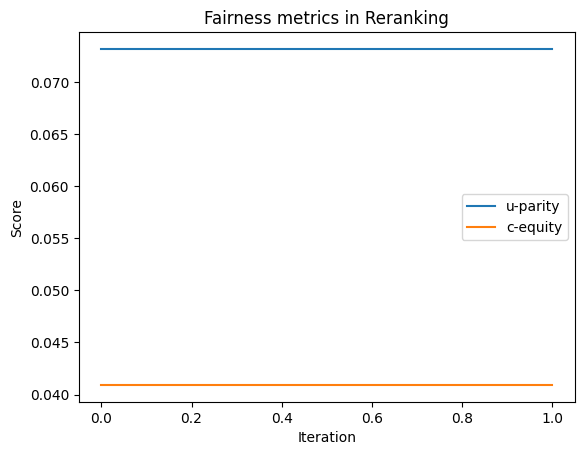

In [132]:
df_result[['u-parity','c-equity']].plot(xlabel='Iteration', ylabel='Score', title='Fairness metrics in Reranking')

In [331]:
df_result.to_csv("ml-agentic-recommender-variant1.csv")

## Tests

In [89]:
user_id = 2

result = agent.invoke(
    {
        "messages": [{"role": "user", "content": f"Recommend movies for the user {user_id}. The user is in {get_user_group(user_id)} group."}],
    },
    config=config,
    context=UserContext(user_id=user_id,session_id=experiment_id),
    
)

print(result['messages'][-1].pretty_print())

[GetUserHistory] user_id: 2
[FilterCandidateSet] User[2], Model: ease, Top K: 20
[GetUserPreferences] User[2] history length: 258
[CheckRecommendations] User[2] - Recommendations length: 10
 --- GetMetrics --- [2]@10 (backbone_model=ease)
Metrics@3: C-Equity: 0.0409 (±0.0425), U-Parity: 0.0732 (±0.0544)
================================= Tool Message =================================
Name: RecommendationResponse

Returning structured response: user_id=2 recommendations=['Casablanca', 'Babe', 'Airplane!', 'Shakespeare in Love', 'The Princess Bride', 'Back to the Future', 'Star Wars: Episode IV - A New Hope', 'Stand by Me', 'Raiders of the Lost Ark', 'Wallace & Gromit: The Best of Aardman Animation']
None


In [133]:
namespace_for_memory = (str(user_id),"recommendations")
store.get(namespace_for_memory,experiment_id)

Item(namespace=['1', 'recommendations'], key='1', value={'recommended_items': ['Babe', 'Star Wars: Episode IV - A New Hope', 'Lady and the Tramp', 'Vertigo', 'North by Northwest', 'To Kill a Mockingbird', 'Star Wars: Episode V - The Empire Strikes Back', 'Psycho', 'Blade Runner', 'The Graduate'], 'user_group': 'protected'}, created_at='2025-12-04T17:50:36.311931+00:00', updated_at='2025-12-04T17:50:36.311933+00:00')

In [134]:
namespace_for_memory = (str(2),)
store.search(namespace_for_memory)

[]

In [135]:
namespace_for_memory = ("metrics","c-equity")
store.search(namespace_for_memory)

[Item(namespace=['metrics', 'c-equity'], key='1', value={'user_id': 0, 'mean': 0.04092017234772063, 'std': 0.04246618579515752}, created_at='2025-12-04T17:50:24.432208+00:00', updated_at='2025-12-04T17:50:24.432209+00:00', score=None),
 Item(namespace=['metrics', 'c-equity'], key='2', value={'user_id': 1, 'mean': 0.04092017234772063, 'std': 0.04246618579515752}, created_at='2025-12-04T17:50:39.833384+00:00', updated_at='2025-12-04T17:50:39.833385+00:00', score=None)]

In [ ]:
# Get all users with recommendation
namespace_for_uparity = ("metrics","u-parity")
u_parity_items = store.search(namespace_for_uparity)
users = [item.value.get('user_id') for item in u_parity_items]
# For each user with recommendation, get the recommended items and the user group
categories_distribution = dict()
for user in users:
    # User Group
    user_group = get_user_group(user)
    if user_group not in categories_distribution:
        categories_distribution[user_group] = dict()

    # Recommended items
    namespace_for_user = (str(user),"recommendations")
    user_items = store.search(namespace_for_user)
    user_recommended_items = user_items[0].value.get("recommended_items")  # WARN: user_items[0] -> only first recommendation per user
    
    # Categories of recommended items
    for movie in user_recommended_items:
        movie_categories = get_movie_genres(movie)
        for category in movie_categories:
            if category not in categories_distribution[user_group]:
                categories_distribution[user_group][category] = 0
            categories_distribution[user_group][category] = categories_distribution[user_group][category] + 1
    

In [141]:
categories_distribution

{'non-protected': {'Action': 2,
  'Drama': 7,
  'Romance': 2,
  'War': 2,
  'Crime': 3,
  'Thriller': 3,
  'Comedy': 1,
  'Film-Noir': 1},
 'protected': {"Children's": 2,
  'Comedy': 2,
  'Drama': 5,
  'Action': 2,
  'Adventure': 2,
  'Fantasy': 1,
  'Sci-Fi': 3,
  'Animation': 1,
  'Musical': 1,
  'Romance': 2,
  'Mystery': 1,
  'Thriller': 3,
  'War': 1,
  'Crime': 1,
  'Horror': 1,
  'Film-Noir': 1}}

In [93]:
namespace_for_system = ("system",)
store.search(namespace_for_system)

[Item(namespace=['system', 'counter'], key='1', value={'recommender_counter': 3}, created_at='2025-12-04T17:22:10.479493+00:00', updated_at='2025-12-04T17:22:10.479497+00:00', score=None)]

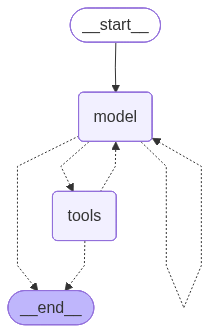

In [29]:
agent

# Print all messages in the result
for message in result['messages']:
    print(message.pretty_print())

In [118]:
result['structured_response']

RecommendationResponse(user_id=123, recommendations=['Back to the Future', "Pee-wee's Big Adventure", 'Forrest Gump', 'The Shawshank Redemption', 'The Silence of the Lambs', 'The Usual Suspects', 'The Sixth Sense', 'Apollo 13', "Jacob's Ladder", 'GoodFellas'])

In [119]:
result['preferences']

'Based on your watchlist, your key preferences seem to include:\n\n1. **Diverse Genres with a Focus on Drama and Thriller:** You enjoy intense narratives, from psychological thrillers (The Silence of the Lambs, The Sixth Sense) to crime and noir (Fargo, Reservoir Dogs, L.A. Confidential).\n\n2. **Strong Character Development and Emotional Depth:** Films like Forrest Gump, Schindler’s List, The Green Mile, and Saving Private Ryan showcase a preference for emotionally compelling stories with memorable characters.\n\n3. **Clever, Thought-Provoking, and Stylish Films:** You appreciate movies with unique storytelling, like Being John Malkovich, Pulp Fiction, Run Lola Run, and The Matrix.\n\n4. **Humor and Quirky Elements:** You include comedies and offbeat films such as Pee-wee’s Big Adventure, Grosse Pointe Blank, Friday, and Clerks, indicating an appreciation for humor and eccentricity.\n\n5. **Awards and Critical Acclaim:** Many of your picks are critically acclaimed or award-winning, re

# Discussed on last meeting

Goal: given a set of users, produce a set of k fair recommendations for each user.

Variant: individual fairness

Variant 1: no fairness + individual

variant2: memory+holistic fairness

-----

Variant2: holistic and no memory

Verify if an LLM is able to enforce fairness

Verify an LLM is able to enforce fairness holistically or individually

Impact of memory on the LLM’s ability to enforce fairness


-> Implementar o componente de memória
-> Pensar em como estruturar os prompts para cada variante com base na memória


In [121]:
resp : RecommendationResponse = result['structured_response']
resp

RecommendationResponse(user_id=123, recommendations=['Back to the Future', "Pee-wee's Big Adventure", 'Forrest Gump', 'The Shawshank Redemption', 'The Silence of the Lambs', 'The Usual Suspects', 'The Sixth Sense', 'Apollo 13', "Jacob's Ladder", 'GoodFellas'])

In [126]:
raw_target_user_id = get_raw_user_ids(ratings_pp, [resp.user_id])[0]
test_ratings[test_ratings.User_id == raw_target_user_id]


,User_id,Item_id,Rating,Timestamp,Gender,datetime
